# Research Methodology (Week 12)

DoA prediction using signals of poor quality

In [2]:
from matplotlib import pyplot as plt
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from collections import namedtuple
import pandas as pd
import os
import numpy as np
import seaborn as sns


<br/>

<br/>

# Create Datasets

In [15]:
def create_dataset(data_dir='training', patient=None): 
    """
    Generate training and test sets based on the 17 features selected from week 6. These 
    include all features with a correlation > 0.15 with the BIS.
    
    
    Parameters
    -----------
    data_dir : {"training", "test"}, default = 'training'
        Create the training or test dataset based on the selected features.
        
    patient : String, default=None
        Create the dataset of a patient. It depends on data_dir parameter i.e. if the
        data_dir is set to 'training', then the patient must be present in the training set,
        otherwise, the patient must be present in the test set.
        
        If None, the dataset of the patient is NOT created.
        
        
    Returns
    --------
    dataset: pd.DataFrame
        The training, test, or patient dataset.
    """
    
    folders = ["SampEntropy_CH2Squared", "Katz_CH2Squared", "SampEntropy", "Katz", "SampEntropy_CH2DenoisedSquared", "Katz_CH2DenoisedSquared", "PermEntropy_CH2DenoisedSquared", "Higuchi_CH2DenoisedSquared", "Petrosian_CH2Squared", "Petrosian", "Petrosian_CH2DenoisedSquared"]
    patient_dict = {}
    
    if data_dir == 'training':
        directory = 'Class A train sets'
        
    if data_dir == 'test':
        directory = 'Class B test sets'

    if data_dir == 'test_sqi':
        # modify the folders
        folders = ["SampEntropy_CH2Squared", "Katz_CH2Squared", "SampEntropy", "Katz", "SampEntropy_CH2DenoisedSquared", "Katz_CH2DenoisedSquared", "Petrosian_CH2Squared", "Petrosian", "Petrosian_CH2DenoisedSquared"]
        directory = 'Class D invalids'
        

    for folder in folders:
        if patient == None:
            # Creating the entire dataset using the data.csv files
            df = pd.read_csv("./{}/{}/Modified/data.csv".format(directory, folder))
            
        if patient != None:
            # Creating datasets for each patient
            try:
                df = pd.read_csv("./{}/{}/Modified/{}".format(directory, folder, patient+'_modified.csv'))
                
            except FileNotFoundError as e:
                print("Patient {} does not exist in the {} set.".format(patient, data_dir))
                print(e)
                return
                

        patient_dict['BIS'] = df['BIS']

        if data_dir == 'test_sqi':
            patient_dict['SQI'] = df['SQI']


        # CH2^2 Folder
        if folder == "Katz_CH2Squared":
            patient_dict['Katz_cA_4'] = df['Katz_cA_4']
            patient_dict['Katz_cD_2'] = df['Katz_cD_2']
            
        if folder == "SampEntropy_CH2Squared":
            patient_dict['SampenCA_4'] = df['SampenCA_4']
            patient_dict['SampenCD_2'] = df['SampenCD_2']


        # New method: Petrosian Fractal Dimension
        if folder == "Petrosian_CH2Squared":
            patient_dict['Petrosian_CA_4'] = df["Petrosian_CA_4"]
            patient_dict['Petrosian_CD_3'] = df["Petrosian_CD_3"]
            
        

        # CH2Denoised Folders
        if folder ==  "SampEntropy":
            patient_dict['SampenCD_2D'] = df['SampenCD_2']
            patient_dict['SampenCA_4D'] = df['SampenCA_4']

        if folder ==  "Katz":
            patient_dict['Katz_cD_2D'] = df['Katz_cD_2']
            patient_dict['Katz_cA_4D'] = df['Katz_cA_4']

        # New method: Petrosian Fractal Dimension
        if folder == "Petrosian":
            patient_dict["Petrosian_CA_4D"] = df["Petrosian_CA_4"]
            patient_dict["Petrosian_CD_3D"] = df["Petrosian_CD_3"]
            patient_dict["Petrosian_CD_1D"] = df["Petrosian_CD_1"]



        # CH2DenoisedSquared Folders
        if folder == "SampEntropy_CH2DenoisedSquared":
            patient_dict['SampenCA_4DS'] = df['SampenCA_4']
            patient_dict['SampenCD_2DS'] = df['SampenCD_2']


        if folder == "Katz_CH2DenoisedSquared":
            patient_dict['Katz_DeltaDS'] = df['Katz_Delta']
            patient_dict['Katz_cD_1DS'] = df['Katz_cD_1']
            patient_dict['Katz_cA_4DS'] = df['Katz_cA_4']
            


        if folder == "PermEntropy_CH2DenoisedSquared":
            patient_dict['Permen_cD_1DS'] = df['Permen_cD_1']
            patient_dict['Permen_cD_3DS'] = df['Permen_cD_3']
            patient_dict['Permen_GammaDS'] = df['Permen_Gamma']


        if folder == "Higuchi_CH2DenoisedSquared":
            patient_dict['Hig_cA_4DS'] = df['Hig_cA_4']


        # New method: Petrosian Fractal Dimension
        if folder == "Petrosian_CH2DenoisedSquared":
            patient_dict["Petrosian_CA_4DS"] = df["Petrosian_CA_4"]
            patient_dict["Petrosian_CD_3DS"] = df["Petrosian_CD_3"]
            patient_dict["Petrosian_CD_1DS"] = df["Petrosian_CD_1"]
            
            
    dataset = pd.DataFrame(patient_dict)
    
    return dataset

<br/>

<div style="border: 2px solid #656565; border-radius: 5px; padding: 2rem 3rem;">
    <h1 style="margin: 0; color: #343d52">Model Building</h1>
</div>

In [5]:
training_df = pd.read_csv("training_set.csv")
training_df.head()

,BIS,SampenCA_4,SampenCD_2,Katz_cA_4,Katz_cD_2,SampenCD_2D,SampenCA_4D,Katz_cD_2D,Katz_cA_4D,SampenCA_4DS,...,Permen_GammaDS,Hig_cA_4DS,Petrosian_CA_4,Petrosian_CD_3,Petrosian_CA_4D,Petrosian_CD_3D,Petrosian_CD_1D,Petrosian_CA_4DS,Petrosian_CD_3DS,Petrosian_CD_1DS
0,95.8,1.118584,1.589795,2.579210,3.842405,0.295259,0.376660,2.220077,2.975620,0.308904,...,0.993749,1.812455,1.027288,1.035669,1.021992,1.036636,1.030315,1.029542,1.036382,1.030116
1,95.8,1.108791,1.578562,2.427762,3.855503,0.317506,0.404385,2.231705,2.945514,0.319252,...,0.993224,1.812594,1.027169,1.035873,1.022235,1.036839,1.030577,1.029542,1.036585,1.030378
2,95.8,1.111692,1.567324,2.581948,3.533784,0.342623,0.442947,2.239327,2.975240,0.328542,...,0.992231,1.810743,1.026573,1.035720,1.022600,1.036940,1.030892,1.029660,1.036636,1.030672
3,95.6,1.122940,1.594337,2.260806,3.837354,0.371085,0.492027,2.246107,2.976338,0.340638,...,0.991169,1.810351,1.026812,1.035516,1.022357,1.037042,1.031184,1.030014,1.036534,1.030954
4,95.6,1.091586,1.622987,2.301977,3.401760,0.403649,0.552274,2.251073,2.993204,0.337477,...,0.990647,1.808214,1.027050,1.035873,1.022478,1.037143,1.031529,1.030014,1.036788,1.031289


<br/>

<br/>

# Redesign of <code>model</code> class to include SQI Checking

In [23]:
class model:
    
    my_model = None

    def __init__(self, model, data, scale=False, verbose=False):
        self.model = model
        self.data = data
        self.scale = scale        
        self.verbose = verbose
            
            
    # Model Selection
    def fit(self, features):
        X = self.data[features]
        y = self.data['BIS']

        
        if self.scale == True:
            scaled_X = StandardScaler()
            scaled_Y = StandardScaler()

            X = scaled_X.fit_transform(X)
            y = scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
            
        
        
        if self.model == "svr":
            my_model = SVR(kernel='rbf', degree=4, gamma='auto', C=10.0)
            my_model.fit(X, y)
            self.my_model = my_model
            
            if self.verbose:
                print("Successfully finished training")
                
            

          #-----------------------------------
          # SUMMING MODELS: Future Experiment
          # --------------- -----------------
#         if self.model == "beta":
#             model_a = HistGradientBoostingRegressor(max_depth=10)
#             model_b = XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.1)
#             model_a.fit(X,y)
#             model_b.fit(X,y)
            
#             self.model_a = model_a
#             self.model_b = model_b




        

            
    # Predict for training or test set
    def predict(self, test_data, features, include_sqi=False, visualize_scatter=False, visualize_line=False, evaluate=False, save=False, x_lims=None):
        
        if self.my_model == None:
            raise Exception("Call the fit() method to train a model")
            
        X = test_data[features]
        y = test_data['BIS']

        if include_sqi:
            sqi = test_data['SQI']

        xmin, xmax = 0, 110
        
        if self.scale == True:
            test_scaled_X = StandardScaler()
            test_scaled_Y = StandardScaler()
            
            X = test_scaled_X.fit_transform(X)
            y = test_scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
            # For the residual plot
            xmin, xmax = -3, 3
            
            
        # Predict
        y_pred = self.my_model.predict(X)
        
        # Metrics
        r2 = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        
#         print("Correlation: \n\n", np.corrcoef(y, y_pred))
        
        
        
        
          #-----------------------------------
          # SUMMING MODELS: Future Experiment
          # --------------- -----------------
        
#         if self.model == "beta":
#             y_pred1 = self.model_a.predict(X)
#             y_pred2 = self.model_b.predict(X)
            
#             y_mean = 0.5* (y_pred1 + y_pred2)
            
            
            
#             figure = plt.figure(figsize=(15, 10))
#             plt.plot(y, label="Actual BIS")
#             plt.plot(y_mean, label="Predicted BIS")
#             plt.xlabel('Samples')
#             plt.ylabel('BIS')
#             plt.legend(loc='upper left')
#             plt.title("Depth of Anaesthesia assessment with EEG")
#             plt.show()
            
#             # print the r2 score
#             print("R^2: ", r2_score(y_mean, y))
            
        if save == True:
            saved_predictions = pd.concat([pd.DataFrame({"Actual BIS": y}), pd.DataFrame({"Predicted BIS": y_pred})], axis=1)
            saved_predictions.to_csv("Saved Predictions.csv")

        
        # Visualize after predicting    
        if visualize_line == True:
            figure = plt.figure(figsize=(15, 10))
            plt.plot(y, c='blue', label="Actual BIS")
            plt.plot(y_pred, c='red', label="Predicted BIS")

            if include_sqi:
                plt.plot(sqi, c='k', label='SQI')
                plt.xlim(x_lims[0], x_lims[1])
                plt.ylim(0, 100)


            plt.xlabel('Time, seconds')
            plt.ylabel('BIS')
            plt.legend(loc='lower right')
            plt.title("Depth of Anaesthesia assessment with EEG")
            plt.show()
            
            
        # scatterplots
        if visualize_scatter == True:
            
            figure = plt.figure(figsize=(15, 10))
            
            # Plot the regression line
            sub_lr = LinearRegression().fit(y[:, np.newaxis], y_pred)
            predictions = sub_lr.predict(y[:, np.newaxis])
            plt.plot(y, predictions, c='red', label='Fitted curve')
            

            
            # Plot the Actual and Predicted BIS
            plt.scatter(y, y_pred, c='royalblue', label='Data')
            
            # Calculate the upper and lower limits to determine outliers
            std = np.std(predictions)
            upper_limit = predictions + 3*std
            lower_limit = predictions - 3*std
            
            # plot the limits
            plt.plot(y, upper_limit, c="k")
            plt.plot(y, lower_limit, c="k")
            
            
            plt.xlabel("Actual BIS")
            plt.ylabel("Predicted BIS")
            plt.legend(loc="lower right")
            plt.title("Depth of Anaesthesia with EEG")
            plt.show()
            
            
            
        if evaluate == True:
            # Residual plot
            figure = plt.figure(figsize=(15, 10))
            plt.plot(y_pred, label='Actual BIS')
            plt.plot(y, label="Predicted BIS")
            plt.ylabel("BIS")
            plt.xlabel("Time, seconds")
            plt.legend(loc='upper left')
            plt.title("Depth of anaesthesia assessment")
            plt.show()
            
            
        Metrics = namedtuple("Metrics", ["r2", "mse"])
            
        # return the coefficient of determination
        return Metrics(r2, mse)
            
            

<br/>

In [11]:
# My best features thus far
test_features_B = ['SampenCD_2D', 'Petrosian_CD_3D', 'SampenCA_4DS', 'Katz_cA_4']

<br/>

# Model: <code>Support Vector Regression</code>

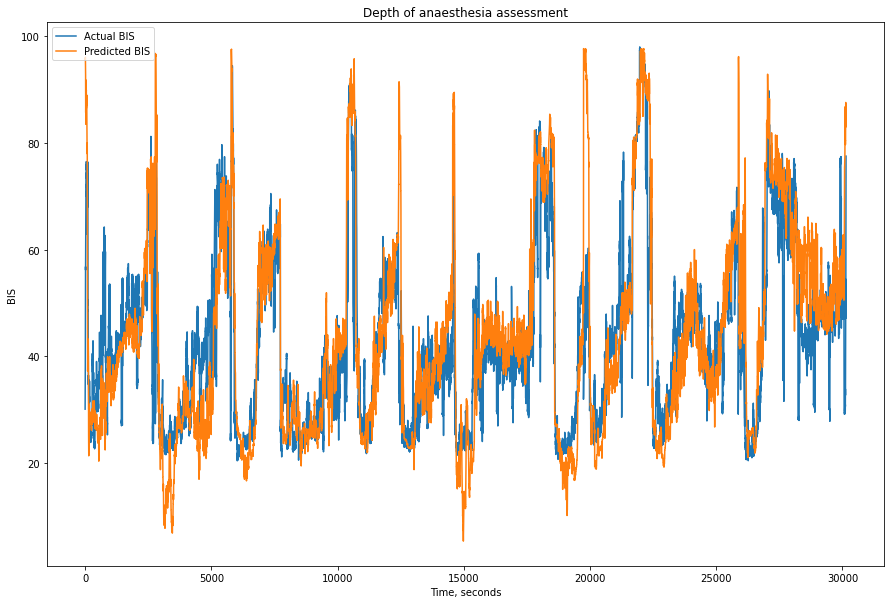

Metrics(r2=0.6491257086120538, mse=127.77105284612634)

In [24]:
# Chosen Model
del svr_B
svr_B = model('svr', training_df)
svr_B.fit(test_features_B)
svr_B.predict(training_df, test_features_B, visualize_scatter=False, evaluate=True)

<br/>

## DoA prediction with signals of poor quality

In [25]:
test_data = [file for file in os.listdir("./Class D invalids") if ".mat" in file]
test_data

['36_09L05201010.mat', '37_09L05251130.mat', '23_EEG200909093.mat']

<br/>

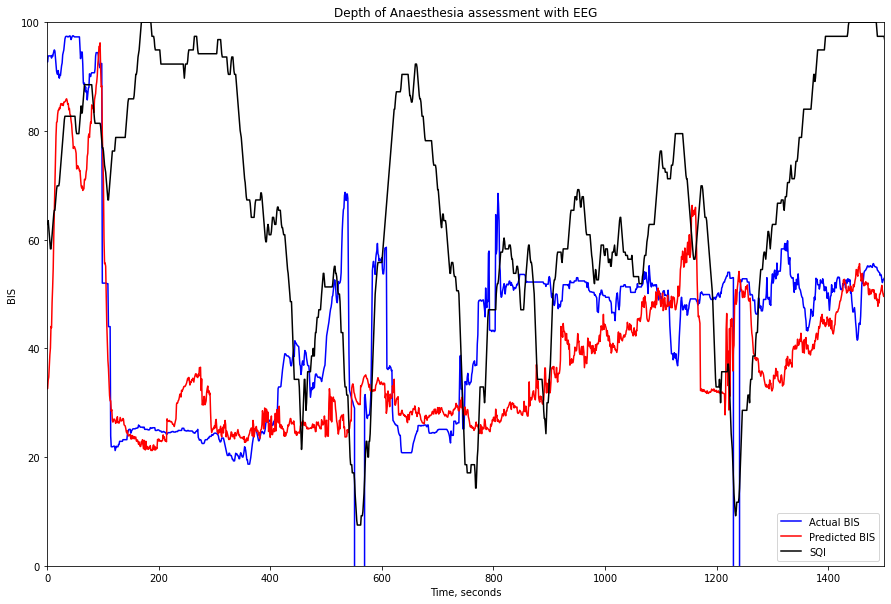

Metrics(r2=-0.0019055480355263388, mse=103926.94750240678)


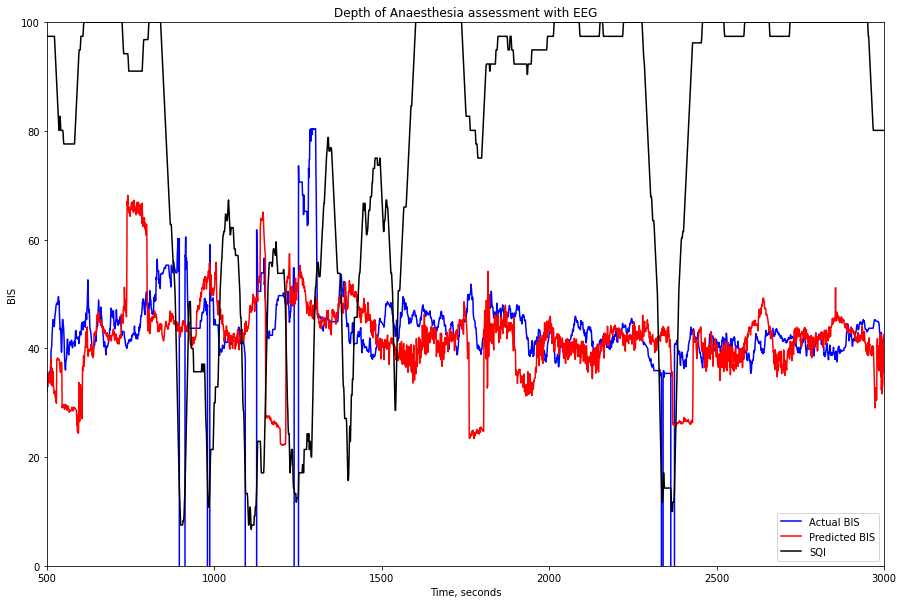

Metrics(r2=-0.012363543367670538, mse=205118.85492008473)


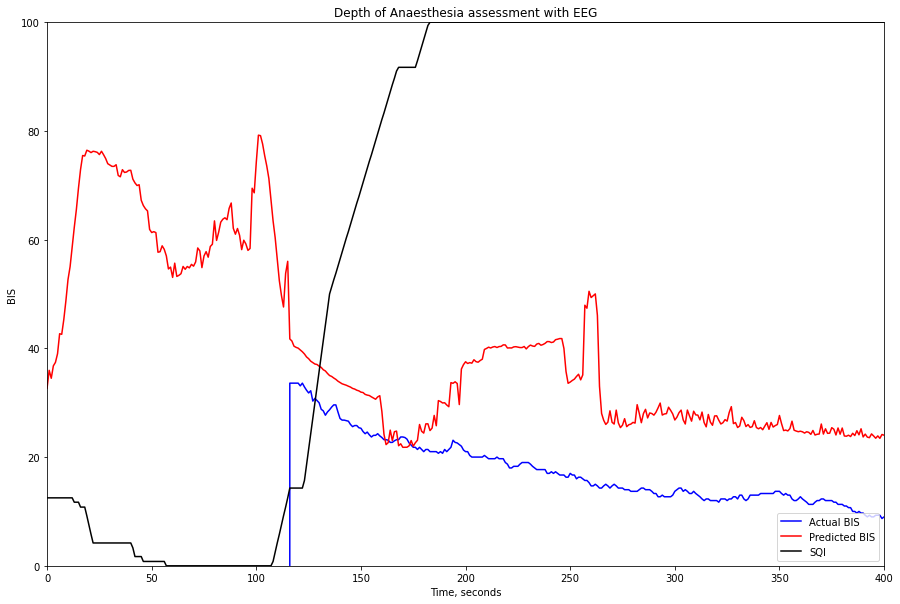

Metrics(r2=-0.10376641745728943, mse=834979.7383384041)


In [26]:
x_lims = [[0, 1500], [500, 3000], [0, 400]]

for idx, test in enumerate(test_data):
    patient = create_dataset(data_dir="test_sqi", patient=test)
    metrics = svr_B.predict(patient, test_features_B, visualize_line=True, include_sqi=True, x_lims=x_lims[idx])
    print(metrics)

<br/>

<br/>

<br/>